In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.datasets import cifar10
import pandas as pd
tf.__version__

'2.8.0'

In [2]:
# check whether GPU can be accessed 
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
def PlotModelEval(Model, History, X, Y, Labels):
    
    # Scores for each class (can be interpreted as probabilities since we use softmax output)
    S = Model.predict(X)
    # Prediction (class number) for each test image
    P = np.expand_dims(np.argmax(S,axis=1), axis=-1)
    # Calculate confusion matrix
    CM = confusion_matrix(Y,P)
    
    # Plot training history
    plt.figure(figsize=(16,6))
    plt.subplot(2,2,1)
    plt.semilogy(History.history['loss'], label="Training")
    if 'val_loss' in History.history:
        plt.semilogy(History.history['val_loss'], label="Validation")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid(True, which="both")
    plt.subplot(2,2,3)
    plt.plot(100 * np.array(History.history['accuracy']), label="Training")
    if 'val_accuracy' in History.history:
        plt.plot(100 * np.array(History.history['val_accuracy']), label="Validation")
    plt.title('Model accuracy')
    plt.ylabel('Acc [%]')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.grid(True, which="both")
    
    # Plot confusion matrix
    plt.subplot(2,2,(2,4)) # assign plot to both slots
    PlotConfusionMatrix(CM, classes=Labels, title="Confusion matrix (test)")
    plt.show()

# ============================================================================

def PlotConfusionMatrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues,
                        showAcc=True):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            verticalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    if showAcc:
        acc = 100*(np.trace(cm) / np.sum(cm))
        title = title + " | Acc=%.2f%%" % acc
        
    plt.title(title)

# ============================================================================

cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [4]:
cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

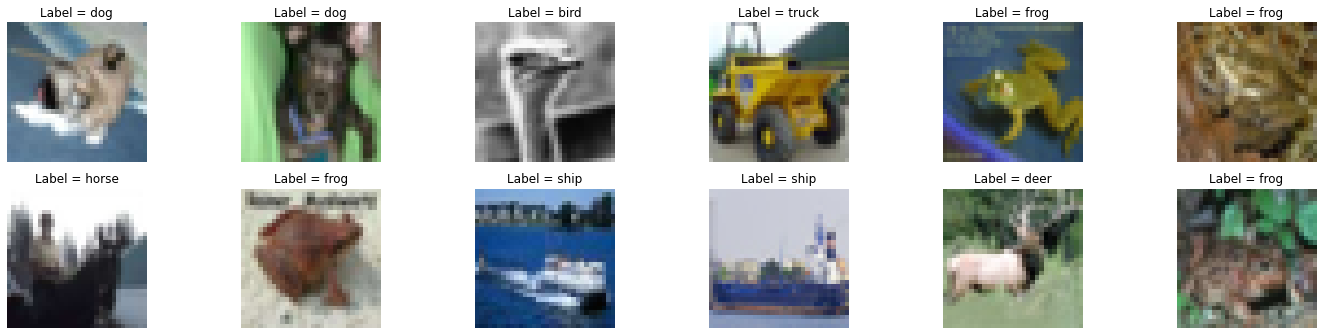

In [5]:
plt.figure(figsize=(20,5))
for i in range(12):
    idx = np.random.randint(0, len(y_train))
    label = y_train[idx,0]
    
    plt.subplot(2,6,i+1)
    plt.tight_layout()
    plt.imshow(X_train[idx])
    plt.title("Label = {}".format(cifar_labels[label]))
    plt.axis('off')
plt.show()

In [6]:
from tensorflow.keras.utils import to_categorical

# Transform label indices to one-hot encoded vectors
y_train = to_categorical(y_train, num_classes=10)
y_test  = to_categorical(y_test , num_classes=10)

# Normalization of pixel values (to [0-1] range)
X_train = X_train.astype('float32') / 255
X_test  = X_test.astype('float32')  / 255

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=90,
                             width_shift_range=0.1, 
                             height_shift_range=0.1,
                             horizontal_flip=True)
#datagen.fit(X_train)
flow = datagen.flow(X_train, y_train, batch_size=9) # Set Batch-size

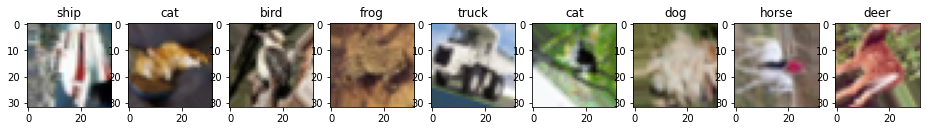

In [8]:
rnd_img_batch = flow.next()

plt.figure(figsize=(16, 64))
for i in range(9):
    plt.subplot(1, 9, i+1)
    image, label = rnd_img_batch[0][i], rnd_img_batch[1][i]
    plt.imshow(image)
    plt.title(cifar_labels[np.argmax(label)])

In [9]:
idX = round(0.2*X_train.shape[0])
X_val, X_train = X_train[:idx, ], X_train[idx:, ]
y_val, y_train = y_train[:idx, ], y_train[idx:, ]

In [10]:
!wandb login "8ecf7403a425fa8a096aeedbe252d23586e2a4cc"

wandb: Appending key for api.wandb.ai to your netrc file: /Users/patrickhiemsch/.netrc


In [11]:
i=25

In [12]:
import wandb
from wandb.keras import WandbCallback

num_classes = 10

# initialize run with hyperparameters 
batch_size = 64
epochs = 200
learning_rate = 0.0025 #0.005 before


wandb.config = {
  "learning_rate": learning_rate,
  "epochs": epochs,
  "batch_size": batch_size
}

wandb.init(project="CIFAR10-Classification", 
           entity="patricksvm",
           config=wandb.config,
           name = f"CIFAR-Run-{i}")

i+=1

wandb: Currently logged in as: patricksvm. Use `wandb login --relogin` to force relogin


In [13]:
import tensorflow.keras as keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping




model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', input_shape=X_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding='same'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), padding='same'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))


model.add(Flatten())
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

#data augmentation
datagen = ImageDataGenerator(rotation_range=25,
                          width_shift_range=0.1, 
                          height_shift_range=0.1,
                          horizontal_flip=True)

#training
flow_train = datagen.flow(X_train, y_train, batch_size=batch_size)

early_stop = EarlyStopping(monitor='val_accuracy', mode='max', patience=25, verbose=1, restore_best_weights=True)

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Nadam(learning_rate=learning_rate), metrics=['accuracy'])
hist = model.fit(flow_train,
          steps_per_epoch=(X_train.shape[0]) // batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val, y_val),
          callbacks=[WandbCallback(),
                    early_stop])

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)          

2022-08-14 22:06:13.407060: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-14 22:06:13.407313: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/200


2022-08-14 22:06:13.669956: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-14 22:06:14.571368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


475/475 [==============================] - ETA: 0s - loss: 1.5450 - accuracy: 0.4489

2022-08-14 22:06:52.399071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


475/475 [==============================] - 51s 103ms/step - loss: 1.5450 - accuracy: 0.4489 - val_loss: 1.1353 - val_accuracy: 0.6041 - _timestamp: 1660507624.0000 - _runtime: 70.0000
Epoch 2/200
475/475 [==============================] - 49s 103ms/step - loss: 1.1371 - accuracy: 0.5945 - val_loss: 0.9890 - val_accuracy: 0.6601 - _timestamp: 1660507673.0000 - _runtime: 119.0000
Epoch 3/200
475/475 [==============================] - 49s 103ms/step - loss: 0.9947 - accuracy: 0.6508 - val_loss: 0.9249 - val_accuracy: 0.6841 - _timestamp: 1660507722.0000 - _runtime: 168.0000
Epoch 4/200
475/475 [==============================] - 49s 103ms/step - loss: 0.9129 - accuracy: 0.6813 - val_loss: 0.7808 - val_accuracy: 0.7332 - _timestamp: 1660507771.0000 - _runtime: 217.0000
Epoch 5/200
475/475 [==============================] - 49s 103ms/step - loss: 0.8518 - accuracy: 0.7033 - val_loss: 0.7842 - val_accuracy: 0.7271 - _timestamp: 1660507820.0000 - _runtime: 266.0000
Epoch 6/200
475/475 [=======

475/475 [==============================] - 51s 107ms/step - loss: 0.4364 - accuracy: 0.8487 - val_loss: 0.4169 - val_accuracy: 0.8574 - _timestamp: 1660509644.0000 - _runtime: 2090.0000
Epoch 43/200
475/475 [==============================] - 51s 106ms/step - loss: 0.4384 - accuracy: 0.8486 - val_loss: 0.5339 - val_accuracy: 0.8297 - _timestamp: 1660509695.0000 - _runtime: 2141.0000
Epoch 44/200
475/475 [==============================] - 50s 106ms/step - loss: 0.4343 - accuracy: 0.8520 - val_loss: 0.4323 - val_accuracy: 0.8540 - _timestamp: 1660509745.0000 - _runtime: 2191.0000
Epoch 45/200
475/475 [==============================] - 51s 107ms/step - loss: 0.4325 - accuracy: 0.8504 - val_loss: 0.3962 - val_accuracy: 0.8659 - _timestamp: 1660509796.0000 - _runtime: 2242.0000
Epoch 46/200
475/475 [==============================] - 51s 108ms/step - loss: 0.4318 - accuracy: 0.8510 - val_loss: 0.4245 - val_accuracy: 0.8577 - _timestamp: 1660509847.0000 - _runtime: 2293.0000
Epoch 47/200
475/4

475/475 [==============================] - 51s 108ms/step - loss: 0.3502 - accuracy: 0.8784 - val_loss: 0.4322 - val_accuracy: 0.8624 - _timestamp: 1660511738.0000 - _runtime: 4184.0000
Epoch 84/200
475/475 [==============================] - 51s 108ms/step - loss: 0.3474 - accuracy: 0.8772 - val_loss: 0.3996 - val_accuracy: 0.8714 - _timestamp: 1660511789.0000 - _runtime: 4235.0000
Epoch 85/200
475/475 [==============================] - 51s 108ms/step - loss: 0.3522 - accuracy: 0.8778 - val_loss: 0.4321 - val_accuracy: 0.8614 - _timestamp: 1660511840.0000 - _runtime: 4286.0000
Epoch 86/200
475/475 [==============================] - 51s 108ms/step - loss: 0.3419 - accuracy: 0.8818 - val_loss: 0.3964 - val_accuracy: 0.8717 - _timestamp: 1660511891.0000 - _runtime: 4337.0000
Epoch 87/200
475/475 [==============================] - 51s 108ms/step - loss: 0.3412 - accuracy: 0.8823 - val_loss: 0.4448 - val_accuracy: 0.8580 - _timestamp: 1660511942.0000 - _runtime: 4388.0000
Epoch 88/200
475/4




========== lr: 0.0025 ==========




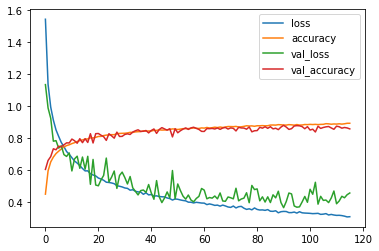

Test loss = 0.391
Test accuracy = 0.878


In [22]:
print(f"\n\n\n========== lr: {learning_rate} ==========")
score = model.evaluate(X_test, y_test, batch_size=128, verbose=0)
print("\n")
pd.DataFrame(hist.history).iloc[:,:4].plot()
plt.show()
for i in range(len(score)):
      print("Test " + model.metrics_names[i] + " = %.3f" % score[i])
